In [1]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [2]:
def is_available(filename):
    if filename.endswith("_0.h5"):
        return False
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_spectra(filename: str):
    with File(filename, "r") as f:
        try:
            x0 = 500
            x1 = f["/photon_diagnostics/Spectrometer/Wavelength"][...]
            a = (
                f["/photon_diagnostics/Spectrometer/WavelengthSpan"][...]
                * f["/photon_diagnostics/Spectrometer/Pixel2micron"][...]
                / 1000
            )
            arr = f["/photon_diagnostics/Spectrometer/hor_spectrum"][...]
            _, n = arr.shape
            x = a * (np.arange(n) - x0) + x1
            for y in arr:
                yield {"x": x, "y": y}
        except KeyError:
            return

In [3]:
df = pd.read_excel("he_levels.xlsx")
df.head()

,n,config,n*,level (eV),dlevel (eV),level,energy (eV),energy,tau,tau (fs),ref
0,2,1s2p 1P,2.009354,21.218023,NaN,0.779742,-3.369366,-0.123821,50.985152,1.233272,1
1,3,1s3p 1P,3.011143,23.087019,1.868996,0.848426,-1.500370,-0.055137,171.580676,4.150338,1
2,4,1s4p 1P,4.011625,23.742070,0.655052,0.872498,-0.845319,-0.031065,405.728343,9.814099,1
3,5,1s5p 1P,5.011826,24.045801,0.303730,0.883660,-0.541588,-0.019903,791.155985,19.137148,1
4,6,1s6p 1P,6.011929,24.211003,0.165202,0.889731,-0.376386,-0.013832,1365.575765,33.031698,1


In [4]:
runs = [160]
globbed = chain.from_iterable(iglob(f"/data/*/Run_{r:03d}/rawdata/*.h5") for r in runs)
filenames = sorted(fn for fn in set(globbed) if is_available(fn))
it = chain.from_iterable(read_spectra(fn) for fn in filenames)

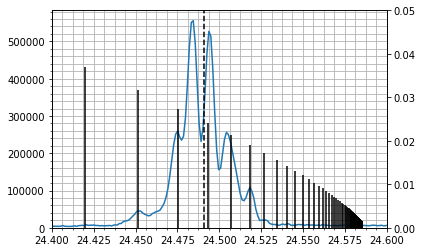

In [5]:
d = next(it)
offset = 0.022
plt.plot(1239.84193 / d["x"] - offset, d["y"])
plt.ylim(0, None)
plt.minorticks_on()
plt.grid(True, which='both')
plt.axvline(24.491 , linestyle='--', color='k')

plt.twinx()
plt.vlines(df["level (eV)"], 0, df["n"]**(-3/2))
plt.xlim(24.4, 24.6)
plt.ylim(0, 0.05)
plt.show()

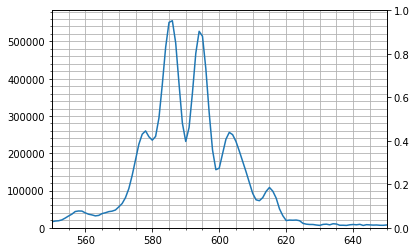

In [7]:
#d = next(it)
plt.plot(d["y"])
plt.ylim(0, None)
plt.minorticks_on()
plt.grid(True, which='both')
#plt.axvline(24.491 , linestyle='--', color='k')

plt.twinx()
plt.xlim(550, 650)
#plt.ylim(0, 0.05)
plt.show()